In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Intentar usar statsmodels, si no está instalamos un fallback
try:
    from statsmodels.tsa.holtwinters import ExponentialSmoothing
    HAS_SM = True
except ImportError:
    HAS_SM = False
    print("⚠ No se encontró 'statsmodels'. Se usará un forecast simple por promedio móvil.")

# Rutas base
BASE_DIR = Path("..")
PROCESSED_DIR = BASE_DIR / "processed"

# Dataset base para series de tiempo
# Preferimos el ICD por registro; si no existe, usamos suelos_coherencia
data_path = PROCESSED_DIR / "suelos_icd_registro.csv"
if not data_path.exists():
    print("⚠ No se encontró suelos_icd_registro.csv, se usará suelos_coherencia.csv")
    data_path = PROCESSED_DIR / "suelos_coherencia.csv"

print("Cargando datos desde:", data_path.resolve())
df = pd.read_csv(data_path)
print("Shape:", df.shape)
df.head()


⚠ No se encontró 'statsmodels'. Se usará un forecast simple por promedio móvil.
Cargando datos desde: D:\ICD-SOIL\processed\suelos_icd_registro.csv
Shape: (35111, 104)


C:\Users\diego\AppData\Local\Temp\ipykernel_25240\2181309024.py:30: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


,secuencial,fecha_de_an_lisis,departamento,municipio,cultivo,estado,tiempo_de_establecimiento,topografia,drenaje,riego,...,icd_comp_zinc_olsen,icd_total_zinc_olsen,icd_comp_boro_disponible,icd_total_boro_disponible,icd_comp_hierro_doble_acido,icd_total_hierro_doble_acido,icd_comp_manganeso_doble_acido,icd_total_manganeso_doble_acido,icd_comp_zinc_doble_acido,icd_total_zinc_doble_acido
0,1,2014-07-01,NARIÑO,SAN ANDRÉS DE TUMACO,No Indica,No indica,No indica,No indica,No indica,No indica,...,1.0,0.968230,1.0,0.968654,0.0,0.489899,0.0,0.489899,0.0,0.489899
1,164,2014-05-09,CUNDINAMARCA,UNE,Lulo,Establecido,De 0 a 1 año,Plano,Buen drenaje,Aspersión,...,1.0,0.971891,1.0,0.908853,0.0,0.489950,0.0,0.489950,0.0,0.489950
2,165,2014-05-09,CUNDINAMARCA,UNE,Lulo,Establecido,De 0 a 1 año,Ondulado,Buen drenaje,Aspersión,...,1.0,0.930250,1.0,0.757292,0.0,0.454320,0.0,0.454320,0.0,0.454320
3,166,2014-05-09,CUNDINAMARCA,FUNZA,Guisantes,Por establecer,No indica,Plano,Buen drenaje,Goteo,...,1.0,0.677736,1.0,0.924875,0.0,0.475861,0.0,0.475861,0.0,0.475861
4,167,2014-05-09,VALLE DEL CAUCA,LA UNIÓN,Guanábana,Establecido,Mas de 10 años,Plano,Buen drenaje,Manguera,...,1.0,0.927205,1.0,0.550316,0.0,0.417193,0.0,0.417193,0.0,0.417193


In [2]:
# Intentar detectar una columna de fecha automáticamente
date_candidates = [
    c for c in df.columns
    if any(k in c.lower() for k in ["fecha", "f_analisis", "f_muestreo", "date"])
]

print("Posibles columnas de fecha encontradas:", date_candidates)

if not date_candidates:
    raise ValueError(
        "No se encontró ninguna columna de fecha en el dataset. "
        "Sin información temporal no es posible hacer forecasting."
    )

DATE_COL = date_candidates[0]
print("Se usará como columna de fecha:", DATE_COL)

# Convertir a datetime
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")

# Quitar filas sin fecha válida y ordenar
df = df.dropna(subset=[DATE_COL]).sort_values(DATE_COL)

print("Rango de fechas:", df[DATE_COL].min(), "→", df[DATE_COL].max())
df[[DATE_COL]].head()


Posibles columnas de fecha encontradas: ['fecha_de_an_lisis']
Se usará como columna de fecha: fecha_de_an_lisis
Rango de fechas: 2014-01-04 00:00:00 → 2025-12-08 00:00:00


,fecha_de_an_lisis
2673,2014-01-04
2595,2014-01-04
2596,2014-01-04
2597,2014-01-04
2598,2014-01-04


In [3]:
# Lista de variables de suelo de interés
VARIABLES_SUELO = [
    "ph_agua_suelo", "materia_organica", "fosforo_bray_ii", "azufre_fosfato_monocalcico",
    "acidez_intercambiable", "aluminio_intercambiable", "calcio_intercambiable",
    "magnesio_intercambiable", "potasio_intercambiable", "sodio_intercambiable",
    "cic", "conductividad_electrica", "hierro_olsen", "cobre_disponible",
    "manganeso_olsen", "zinc_olsen", "boro_disponible",
    "hierro_doble_acido", "cobre_disponible_doble_acido", "manganeso_doble_acido", "zinc_doble_acido"
]

vars_present = [v for v in VARIABLES_SUELO if v in df.columns]
print(f"Variables de suelo disponibles ({len(vars_present)}):")
print(vars_present)

# Parámetros del forecasting
FREQ = "MS"       # 'MS' = comienzo de mes (Month Start)
HORIZON = 12      # número de pasos a futuro
MIN_PUNTOS = 10   # mínimo de puntos para generar modelo

print("\nSe usará frecuencia:", FREQ)
print("Horizonte de pronóstico:", HORIZON, "pasos")
print("Mínimo de puntos históricos para modelar:", MIN_PUNTOS)


Variables de suelo disponibles (21):
['ph_agua_suelo', 'materia_organica', 'fosforo_bray_ii', 'azufre_fosfato_monocalcico', 'acidez_intercambiable', 'aluminio_intercambiable', 'calcio_intercambiable', 'magnesio_intercambiable', 'potasio_intercambiable', 'sodio_intercambiable', 'cic', 'conductividad_electrica', 'hierro_olsen', 'cobre_disponible', 'manganeso_olsen', 'zinc_olsen', 'boro_disponible', 'hierro_doble_acido', 'cobre_disponible_doble_acido', 'manganeso_doble_acido', 'zinc_doble_acido']

Se usará frecuencia: MS
Horizonte de pronóstico: 12 pasos
Mínimo de puntos históricos para modelar: 10


In [4]:
def forecast_series(ts: pd.Series, horizon: int = 12, freq: str = "MS"):
    """
    Recibe una serie de tiempo ts (DatetimeIndex con frecuencia fija, sin NaN),
    devuelve un DataFrame con histórico + pronóstico.
    """
    ts = ts.dropna()

    if len(ts) < MIN_PUNTOS:
        print("⚠️ Serie muy corta, longitud:", len(ts))
        return None

    # Asegurar frecuencia fija en el índice
    ts = ts.asfreq(freq)

    # Intentar con ExponentialSmoothing si está disponible
    if HAS_SM:
        try:
            model = ExponentialSmoothing(
                ts,
                trend="add",
                seasonal=None,
                initialization_method="estimated"
            )
            fitted = model.fit(optimized=True)
            forecast = fitted.forecast(horizon)

        except Exception as e:
            print("⚠️ Error en ExponentialSmoothing, se aplica forecast por promedio móvil. Error:", str(e))
            window = min(12, len(ts))
            mean_value = ts.tail(window).mean()

            last_date = ts.index.max()
            forecast_index = pd.date_range(
                last_date + pd.tseries.frequencies.to_offset(freq),
                periods=horizon,
                freq=freq
            )
            forecast = pd.Series(mean_value, index=forecast_index)
    else:
        # Fallback si no hay statsmodels
        window = min(12, len(ts))
        mean_value = ts.tail(window).mean()
        last_date = ts.index.max()
        forecast_index = pd.date_range(
            last_date + pd.tseries.frequencies.to_offset(freq),
            periods=horizon,
            freq=freq
        )
        forecast = pd.Series(mean_value, index=forecast_index)

    # Construir DataFrame combinado
    df_hist = pd.DataFrame({
        "fecha": ts.index,
        "valor": ts.values,
        "tipo": "historico"
    })

    df_fore = pd.DataFrame({
        "fecha": forecast.index,
        "valor": forecast.values,
        "tipo": "forecast"
    })

    return pd.concat([df_hist, df_fore], ignore_index=True)



📈 Generando forecast global para: ph_agua_suelo ...
Longitud de la serie mensual: 144


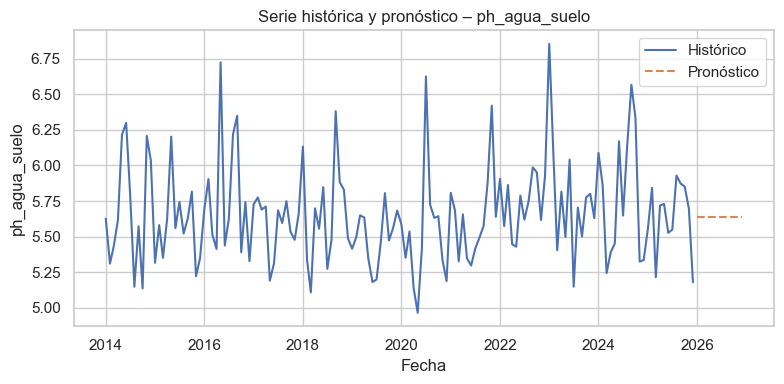


📈 Generando forecast global para: materia_organica ...
Longitud de la serie mensual: 144


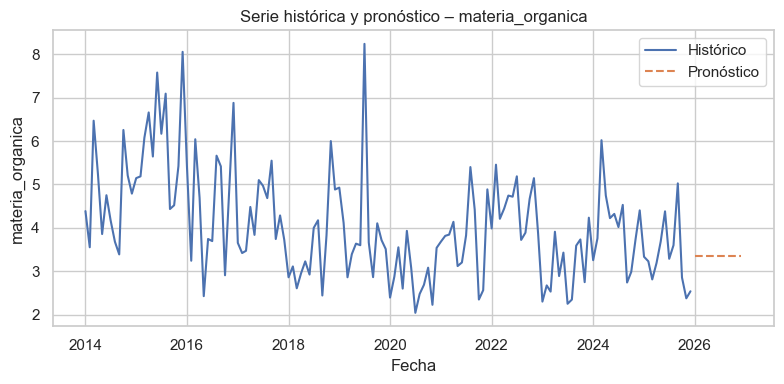


📈 Generando forecast global para: fosforo_bray_ii ...
Longitud de la serie mensual: 144


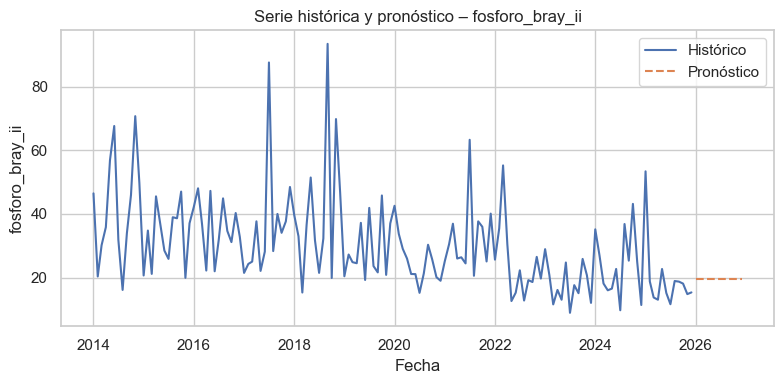


📈 Generando forecast global para: azufre_fosfato_monocalcico ...
Longitud de la serie mensual: 144


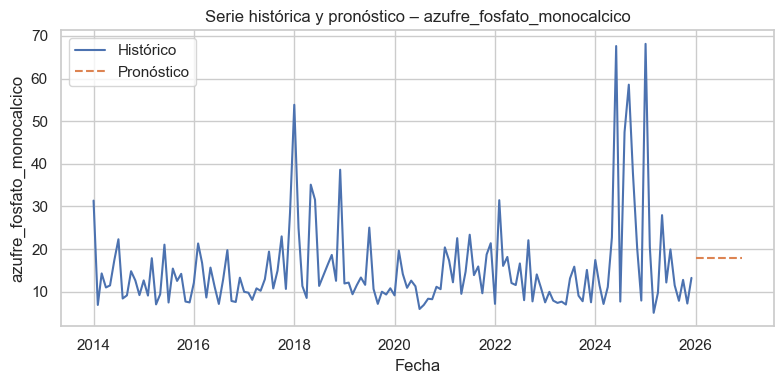


📈 Generando forecast global para: acidez_intercambiable ...
Longitud de la serie mensual: 144


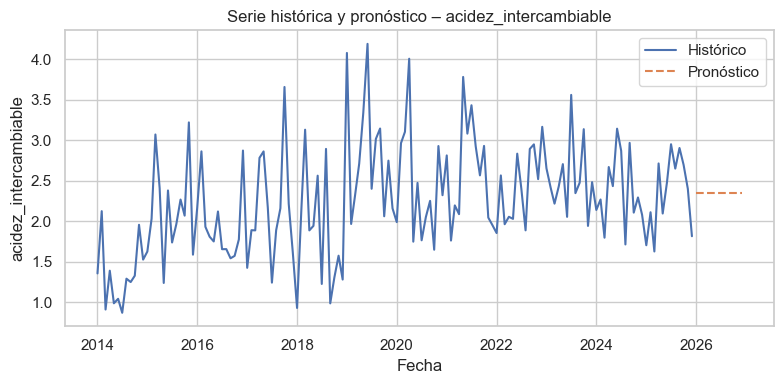


📈 Generando forecast global para: aluminio_intercambiable ...
Longitud de la serie mensual: 144


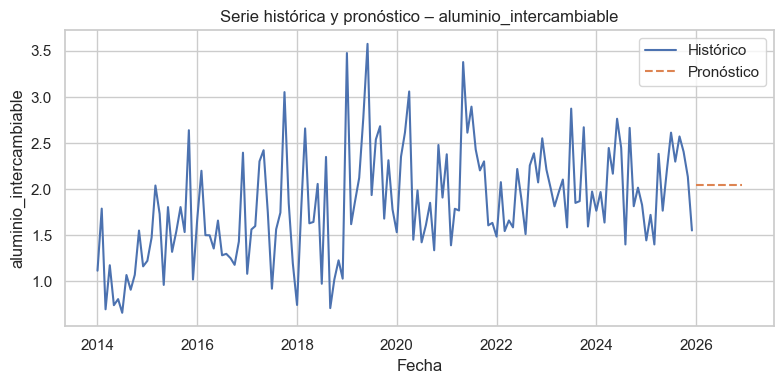


📈 Generando forecast global para: calcio_intercambiable ...
Longitud de la serie mensual: 144


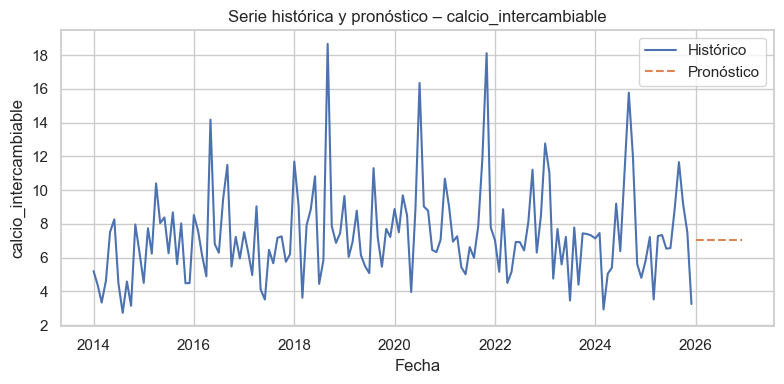


📈 Generando forecast global para: magnesio_intercambiable ...
Longitud de la serie mensual: 144


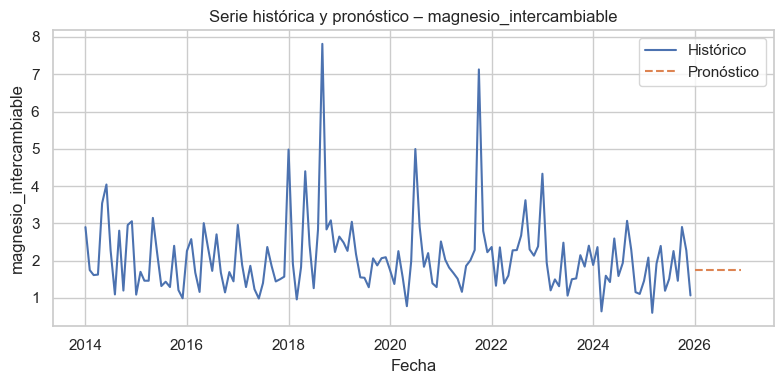


📈 Generando forecast global para: potasio_intercambiable ...
Longitud de la serie mensual: 144


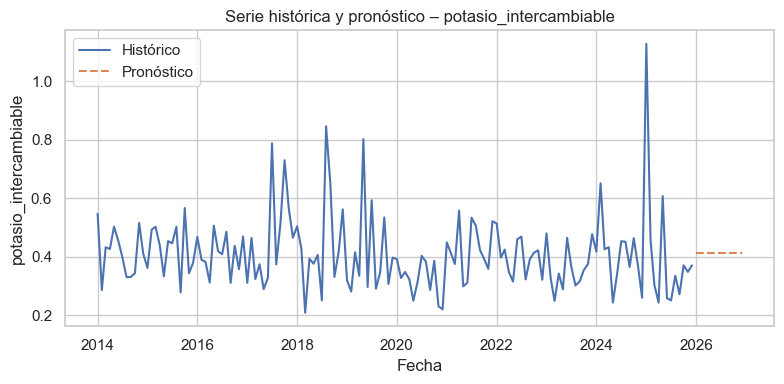


📈 Generando forecast global para: sodio_intercambiable ...
Longitud de la serie mensual: 144


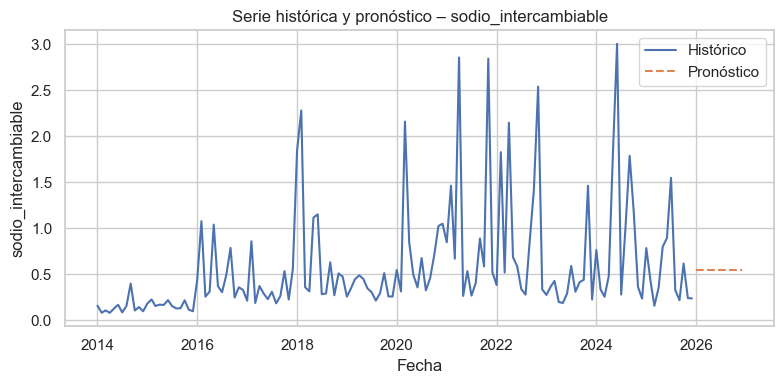


📈 Generando forecast global para: cic ...
Longitud de la serie mensual: 144


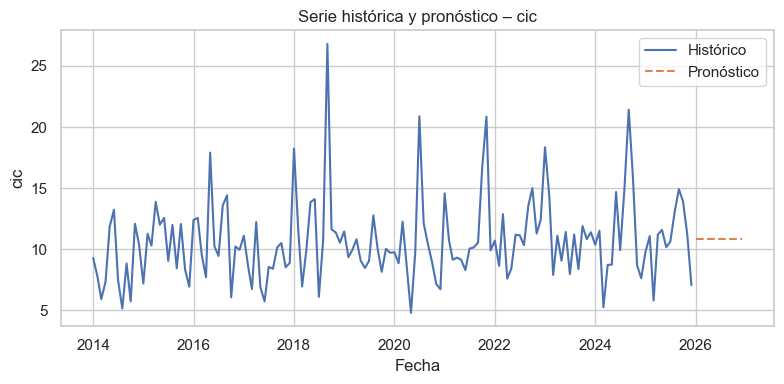


📈 Generando forecast global para: conductividad_electrica ...
Longitud de la serie mensual: 144


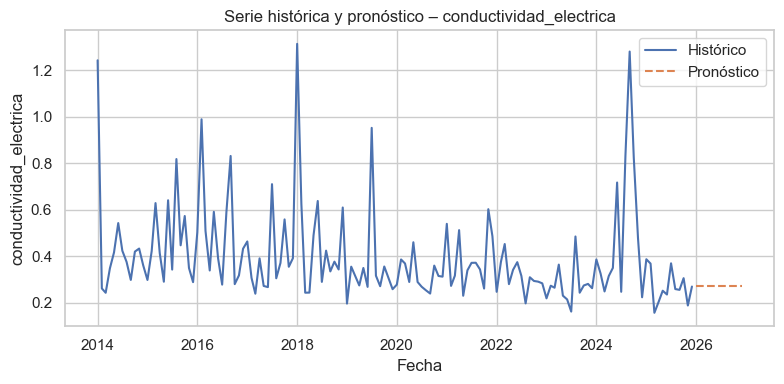


📈 Generando forecast global para: hierro_olsen ...
Longitud de la serie mensual: 144


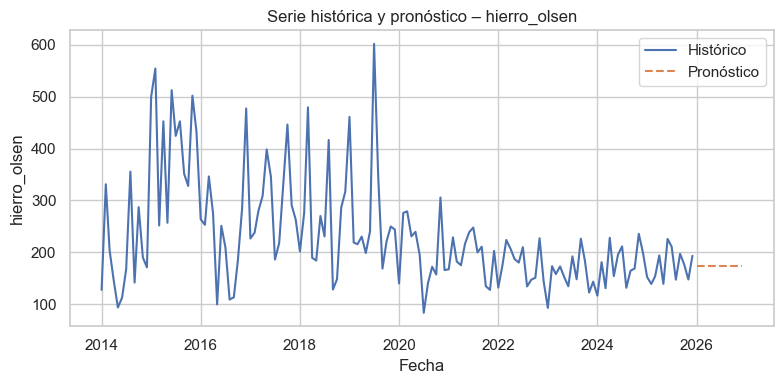


📈 Generando forecast global para: cobre_disponible ...
Longitud de la serie mensual: 144


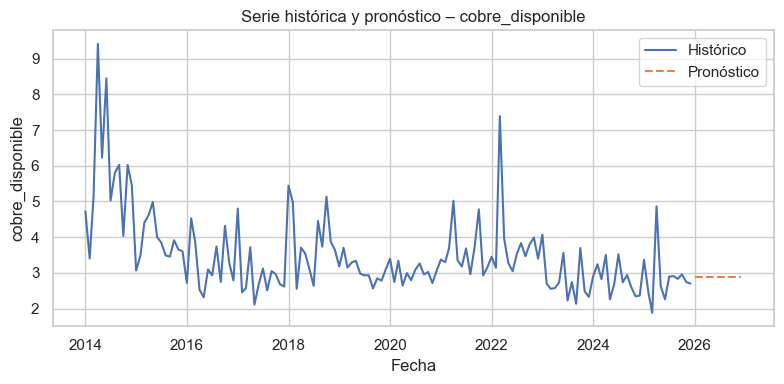


📈 Generando forecast global para: manganeso_olsen ...
Longitud de la serie mensual: 144


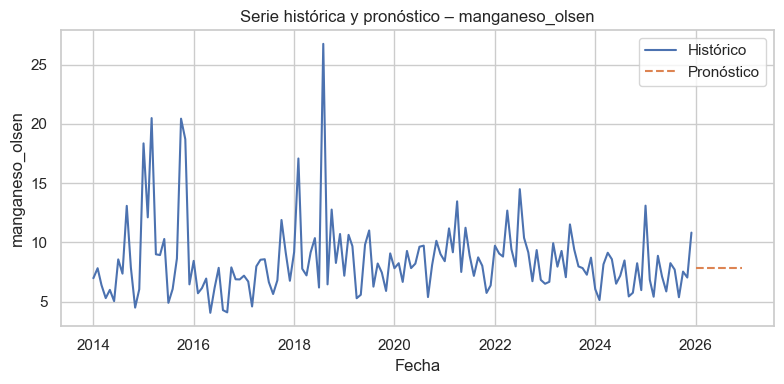


📈 Generando forecast global para: zinc_olsen ...
Longitud de la serie mensual: 144


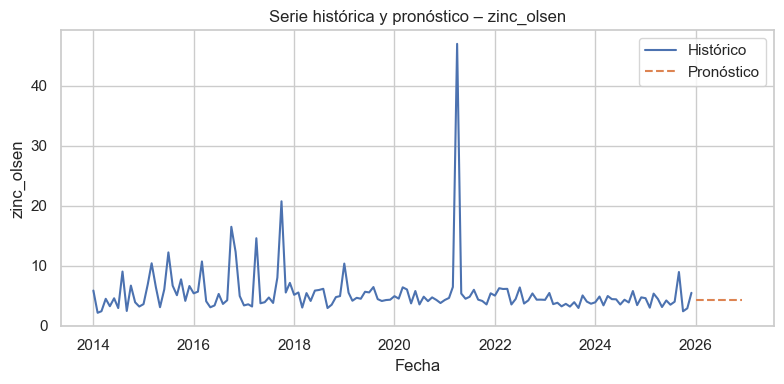


📈 Generando forecast global para: boro_disponible ...
Longitud de la serie mensual: 144


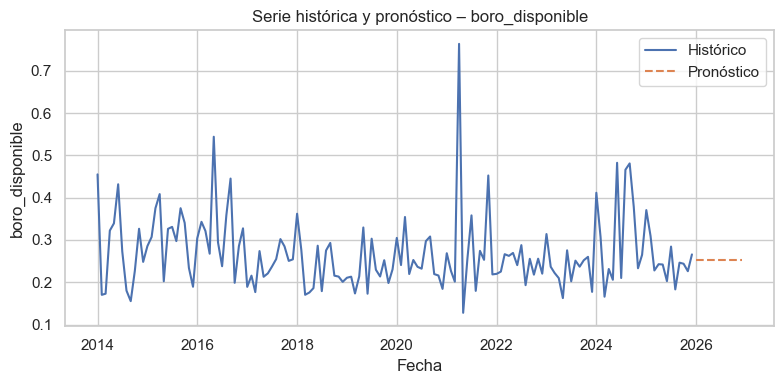


📈 Generando forecast global para: hierro_doble_acido ...
Longitud de la serie mensual: 144


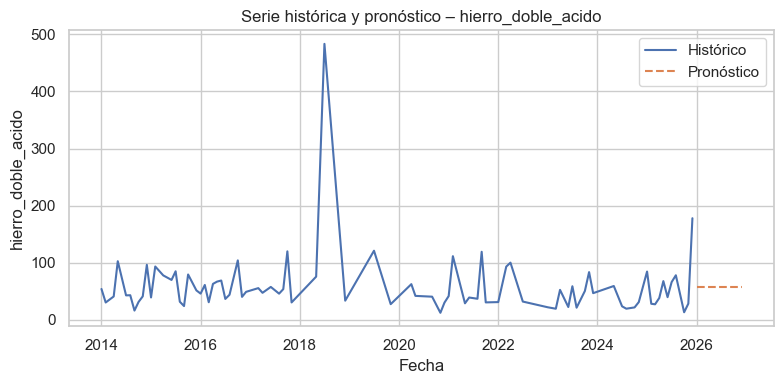


📈 Generando forecast global para: cobre_disponible_doble_acido ...
Longitud de la serie mensual: 144


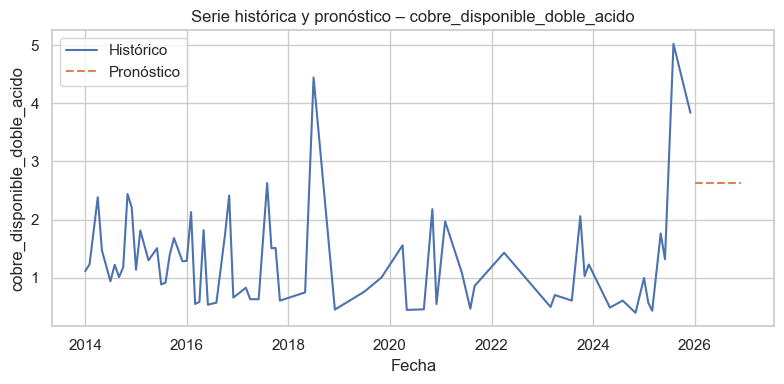


📈 Generando forecast global para: manganeso_doble_acido ...
Longitud de la serie mensual: 144


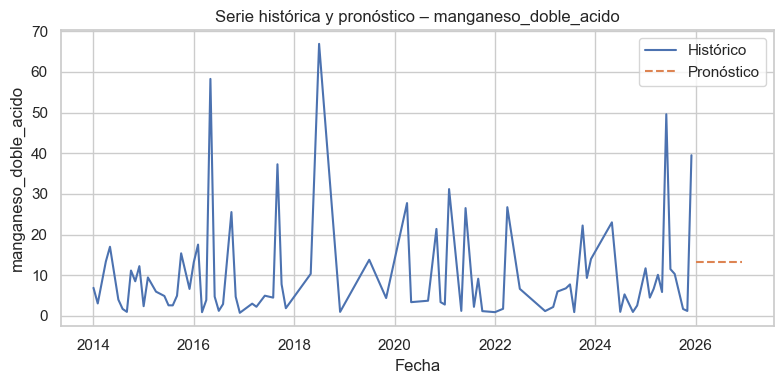


📈 Generando forecast global para: zinc_doble_acido ...
Longitud de la serie mensual: 44


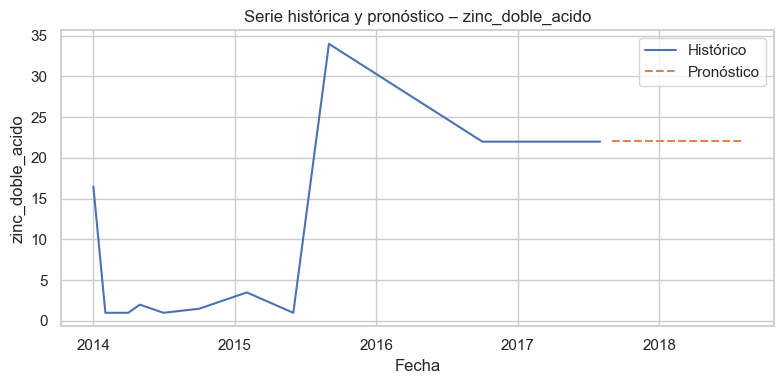


✨ Forecast completado para variables procesadas:
['ph_agua_suelo', 'materia_organica', 'fosforo_bray_ii', 'azufre_fosfato_monocalcico', 'acidez_intercambiable', 'aluminio_intercambiable', 'calcio_intercambiable', 'magnesio_intercambiable', 'potasio_intercambiable', 'sodio_intercambiable', 'cic', 'conductividad_electrica', 'hierro_olsen', 'cobre_disponible', 'manganeso_olsen', 'zinc_olsen', 'boro_disponible', 'hierro_doble_acido', 'cobre_disponible_doble_acido', 'manganeso_doble_acido', 'zinc_doble_acido']


In [5]:
forecasts_global = []
vars_modeladas = []

for var in vars_present:
    print(f"\n📈 Generando forecast global para: {var} ...")

    # Serie de tiempo: promedio nacional por fecha
    # 👉 Convertimos a numérico para evitar problemas de dtype=object
    ts_raw = df.set_index(DATE_COL)[var]
    ts_raw = pd.to_numeric(ts_raw, errors="coerce")  # fuerza a float, 'ND' → NaN

    ts_var = ts_raw.dropna()

    if ts_var.empty:
        print(f"⏭  Sin datos numéricos válidos para {var}. Se omite.")
        continue

    # Resampleo mensual y suavizado (aseguramos frecuencia fija y sin NaN)
    ts_var_m = (
        ts_var
        .resample(FREQ)
        .mean()
        .interpolate(method="time")   # rellena meses faltantes según tiempo
    )

    print("Longitud de la serie mensual:", len(ts_var_m))

    if len(ts_var_m) < MIN_PUNTOS:
        print(f"⏭  Serie mensual demasiado corta para {var}. Se omite.")
        continue

    serie_forecast = forecast_series(ts_var_m, horizon=HORIZON, freq=FREQ)

    if serie_forecast is None:
        print(f"⏭  No se pudo generar forecast para {var}.")
        continue

    serie_forecast["variable"] = var
    forecasts_global.append(serie_forecast)
    vars_modeladas.append(var)

    # Gráfico rápido para inspección
    plt.figure(figsize=(8, 4))
    mask_hist = serie_forecast["tipo"] == "historico"
    mask_fore = serie_forecast["tipo"] == "forecast"

    plt.plot(serie_forecast.loc[mask_hist, "fecha"],
             serie_forecast.loc[mask_hist, "valor"],
             label="Histórico")
    plt.plot(serie_forecast.loc[mask_fore, "fecha"],
             serie_forecast.loc[mask_fore, "valor"],
             "--", label="Pronóstico")

    plt.title(f"Serie histórica y pronóstico – {var}")
    plt.xlabel("Fecha")
    plt.ylabel(var)
    plt.legend()
    plt.tight_layout()
    plt.show()

print("\n✨ Forecast completado para variables procesadas:")
print(vars_modeladas)


In [6]:
if forecasts_global:
    df_forecast_all = pd.concat(forecasts_global, ignore_index=True)

    # Asegurarnos de tipos correctos
    df_forecast_all["fecha"] = pd.to_datetime(df_forecast_all["fecha"])
    df_forecast_all["variable"] = df_forecast_all["variable"].astype(str)
    df_forecast_all["tipo"] = df_forecast_all["tipo"].astype(str)

    df_forecast_all.head()
else:
    df_forecast_all = None
    print("⚠️ No se generó ningún forecast. Revisa disponibilidad de datos y parámetros.")


In [7]:
# Guardar resultado global de forecasting (lo usa el Libro 08 y la app)
if df_forecast_all is not None:
    out_path = PROCESSED_DIR / "forecast_global_por_variable.csv"
    df_forecast_all.to_csv(out_path, index=False, encoding="utf-8")
    print("💾 Forecast global por variable guardado en:", out_path.resolve())
else:
    print("⚠️ No se guardó archivo de forecast porque no hubo resultados.")


💾 Forecast global por variable guardado en: D:\ICD-SOIL\processed\forecast_global_por_variable.csv


Ejemplo de variable para visualizar: ph_agua_suelo


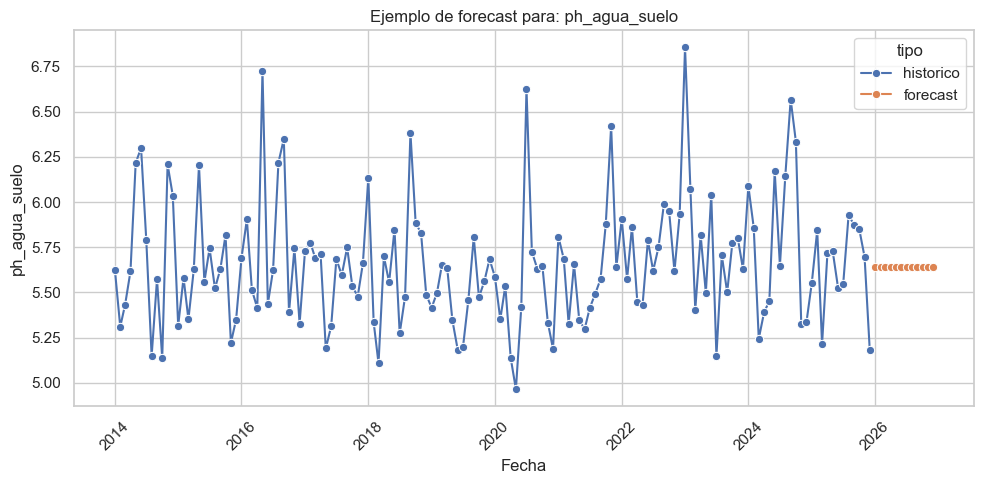

In [8]:
if df_forecast_all is not None:
    # Escoger una variable cualquiera que tenga forecast
    ejemplo_var = df_forecast_all["variable"].unique()[0]
    print("Ejemplo de variable para visualizar:", ejemplo_var)

    df_ej = df_forecast_all[df_forecast_all["variable"] == ejemplo_var].copy()

    plt.figure(figsize=(10, 5))
    sns.lineplot(data=df_ej, x="fecha", y="valor", hue="tipo", marker="o")
    plt.title(f"Ejemplo de forecast para: {ejemplo_var}")
    plt.xlabel("Fecha")
    plt.ylabel(ejemplo_var)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
